#About the Data

* The data was taken from 
https://m.rbi.org.in//scripts/PublicationReportDetails.aspx?ID=242

* Each rule is considered as a record under the the headings:<br>

  1. Enhancing Bank Transparency
  2. Best Practices for Credit Risk Disclosure
  3. Supervision of Financial Conglomerates 
  4. Risk Concentrations Principles
  5. Intra-Group Transactions and Exposures Principles
  6. Principles for the Supervision of Banks’ Foreign Establishments (The Basel Concordat)
  7. Information Flows Between Banking Supervisory Authorities
  8. Minimum Standards for the Supervision of 
International Banking Groups and their Cross-Border Establishments
  9. The Supervision of Cross-Border Banking 
  
* Rules are seperated by their rule number.


# Text Preprocessing

* The line break ‘\n’ is removed from the text, if there exist any.

* Round and square parantheses are removed, if there exist any.

* Text contatined within round paranthesis are removed, if there exist any.

* Text contatined within square paranthesis are removed, if 
there exist any.

* The stop words are removed manully if they are not the beginning and end word in a sentence. The stop words are 
'a','are','shall','those','the','which','has','been','of','by','to','at','is','an','in','for','be','it' and 'such'.

* No summarization was done.

#Fine Tuning DistilBERT model for text classification

* The model was trained on 15 epochs and the learning rate was set at 2e-5 and batch size 8

* Total time taken to create the dataframe with top 3 rank of predictions in the test data is : 0:00:43 (h:mm:ss)

* Data Split:<br>
      -Training data: 149 (50 percent)
      -Validation data: 74 (Around 25 percent)
      -Test Data : 75 (Around 25 percent)

* Macro-averaged f1-score<br>
      -Training data: 0.92
      -Validation data: 0.30
      -Test data: 0.27 



##Memory Allocated

In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

13G


##Google Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Path

In [ ]:
# write the appropriate paths to retrieve the data and store results 
saved_path = '/content/drive/MyDrive/Full_Code/RBI/Stopwords_Removed/Epochs_15/'
used_test_data_path = saved_path  + "Test_data_DistilBERT.csv"

## Set-up environment

Install the libraries folium version 0.2.1, HuggingFace Transformers and Datasets

In [ ]:
#Install the package folium version 0.2.1 and HuggingFace tranformer and datasets libraries  
!pip install -q folium==0.2.1 transformers datasets 

     |████████████████████████████████| 69 kB 4.9 MB/s 
     |████████████████████████████████| 4.2 MB 36.9 MB/s 
     |████████████████████████████████| 346 kB 73.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 85.7 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 76.0 MB/s 
     |████████████████████████████████| 1.1 MB 52.3 MB/s 
     |████████████████████████████████| 140 kB 70.2 MB/s 
     |████████████████████████████████| 127 kB 52.8 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 271 kB 55.3 MB/s 
     |████████████████████████████████| 144 kB 72.7 MB/s 


In [ ]:
#Check if GPU is available
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cpu is available


## Loading the Dataset

In [ ]:
#Load the data
import pandas as pd
test_data_df = pd.read_csv(used_test_data_path)
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  75 non-null     object
 1   label     75 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


Example

In [ ]:
test_data_df.loc[0,'sentence']

'RBI present not normally following practice asking external auditors verify accuracy reporting returns or compliance with any special conditions.'

In [ ]:
test_data_df.loc[0,'label']

'Information Flows Between Banking Supervisory Authorities'

In [ ]:
#Import the librarires required for the function get_top3_rank
import torch
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import logging
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW 
from transformers import pipeline
import numpy as np
import time

In [ ]:
#Create a function for formatting elapsed times as hh:mm:ss
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_top3_rank(df,column_name):
  """
  df: the input dataframe containg text
  column_name : the text column containg the input text
  the function get_top3_rank outputs rank_df the dataframe that contains the top 3 ranks
  """
  ############################################################################################################
  #Function to create DistilBERT pipeline
  ############################################################################################################
  def get_rank_dataframe(df,column_name):
    """
    df: the input dataframe containg text
    column_name : the text column containg the input text
    the function get_rank_dataframe returns the dataframe with top3 ranks
    """
    ############################################################################################################
    #Check if GPU is Available or not
    ############################################################################################################
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    ############################################################################################################
    #Write the appropriate paths to retrieve the data 
    ############################################################################################################
    user_path = '/content/drive/MyDrive/Full_Code/RBI/Stopwords_Removed/Epochs_15/'
    best_model_path = user_path + "best_model/best_model.pt"
    label2id_df_path = user_path + "label2id_df.csv"
    ############################################################################################################
    #Create a label2id dictionary to map label and index
    ############################################################################################################
    labels2id_df = pd.read_csv(label2id_df_path)
    labels = labels2id_df.columns.to_list()
    ids = [int(i) for i in labels2id_df.loc[0,:]]
    id2label = {A: B for A, B in zip(ids, labels)} 
    label2id = {A: B for A, B in zip(labels,ids)} 
    labels = list(labels)
    ############################################################################################################
    #Load the tokenizer
    ############################################################################################################
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))
    logging.set_verbosity_error()
    ############################################################################################################
    #Load the best model
    ############################################################################################################
    model_best = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)


    model_best.to(device)
    ############################################################################################################
    #SET THE PARAMETERS
    fixed_learning_rate = 2e-5
    fixed_batch_size = 8
    ############################################################################################################
    #LOAD THE OPTIMZER
    #Optimizer
    optimizer_best = AdamW(model_best.parameters(),lr = fixed_learning_rate)
    ############################################################################################################
    # The function load_chkp is created for loading model
    def load_ckp(checkpoint_fpath, model, optimizer):
      """
      checkpoint_path: path to save checkpoint
      model: model that we want to load checkpoint parameters into       
      optimizer: optimizer we defined in previous training
      """
      # load check point
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
      # initialize state_dict from checkpoint to model
      model.load_state_dict(checkpoint['state_dict'])
      # initialize optimizer from checkpoint to optimizer
      optimizer.load_state_dict(checkpoint['optimizer'])
      # initialize valid_loss_min from checkpoint to valid_loss_min
      valid_loss_min = checkpoint['valid_loss_min']
      # return model, optimizer, epoch value, min validation loss 
      return model, optimizer, checkpoint['epoch'], valid_loss_min

    # load the saved checkpoint
    model_best, optimizer_best, end_epoch, valid_loss_min = load_ckp(best_model_path, model_best, optimizer_best)
    ############################################################################################################
    #Get inference from the DistilBERT pipline
    ############################################################################################################  
    #set the device_value
    if device == 'cuda:0':
        device_value = 0
    else:
        device_value =-1

     #Create the DistilBERT pipeline
    MAX_LENGTH = model_best.config.max_position_embeddings
  
    distilbert_nlp = pipeline(task="sentiment-analysis", return_all_scores = True, model=model_best, tokenizer=tokenizer,
                              device= device_value, max_length = MAX_LENGTH , truncation=True)
    ############################################################################################################
    #Return the result in a data frame
    ############################################################################################################
    labels_rank_list=[]
    labels_score_list=[]
    def get_rank(example,fix_rank = 3):
      result_value = distilbert_nlp(example)
      sorted_value = sorted(result_value[0], key=lambda k: k['score'],reverse = True)
      new_dictionary_label = {'predicted_label_' + str(i+1): sorted_value[i]['label'] for i in range(fix_rank)}
      new_dictionary_score = {'predicted_percentage_' + str(i+1): 100 * sorted_value[i]['score'] for i in range(fix_rank)}
      labels_rank_list.append(new_dictionary_label)
      labels_score_list.append(new_dictionary_score)
    df[column_name].map(lambda row : get_rank(row,fix_rank = 3))
    list2d_rank = {key: [i[key] for i in labels_rank_list] for key in labels_rank_list[0]}
    list2d_score = {key: [i[key] for i in labels_score_list] for key in labels_score_list[0]}
    predicted_dataframe = pd.concat([df,pd.DataFrame(list2d_rank),pd.DataFrame(list2d_score)], axis=1)
    predicted_dataframe.rename(columns = {'label':'true_label'}, inplace = True)
    return predicted_dataframe
  start_t0 = time.time()
  rank_df = get_rank_dataframe(df,column_name)
  print("\nTotal time taken to create the dataframe: {:} (h:mm:ss)".format(format_time(time.time() - start_t0)))
  return rank_df

In [ ]:
#Call the function get_top3_rank using the input test_data_df and 'sentence' column in test_data_df to return the dataframe with top 3 rank
top3_df = get_top3_rank(test_data_df,'sentence')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]


Total time taken to create the dataframe: 0:00:43 (h:mm:ss)


In [ ]:
#Display the first five entries in the data frame top3_df
top3_df.head()

,sentence,true_label,predicted_label_1,predicted_label_2,predicted_label_3,predicted_percentage_1,predicted_percentage_2,predicted_percentage_3
0,RBI present not normally following practice as...,Information Flows Between Banking Supervisory ...,The Supervision of Cross-Border Banking,Supervision of Financial Conglomerates,Information Flows Between Banking Supervisory ...,38.782677,18.351923,16.910426
1,Summarised data significant concentrations for...,Enhancing Bank Transparency,Enhancing Bank Transparency,Supervision of Financial Conglomerates,Best Practices for Credit Risk Disclosure,96.366936,0.870517,0.700731
2,In India information being furnished on regula...,Enhancing Bank Transparency,Enhancing Bank Transparency,Supervision of Financial Conglomerates,Best Practices for Credit Risk Disclosure,97.376209,0.575449,0.533174
3,Foreign banks operating country required bring...,Principles for the Supervision of Banks’ Forei...,Information Flows Between Banking Supervisory ...,The Supervision of Cross-Border Banking,Principles for the Supervision of Banks’ Forei...,34.480891,20.203142,11.572597
4,Directors’ or top management report annual rep...,Enhancing Bank Transparency,Enhancing Bank Transparency,Best Practices for Credit Risk Disclosure,Supervision of Financial Conglomerates,96.925151,0.724927,0.557958


Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
label2id_df_path = '/content/drive/MyDrive/Full_Code/RBI/Stopwords_Removed/Epochs_15/label2id_df.csv'
labels2id_df = pd.read_csv(label2id_df_path)
labels2id_df

,Best Practices for Credit Risk Disclosure,Enhancing Bank Transparency,Information Flows Between Banking Supervisory Authorities,Intra-Group Transactions and Exposures Principles,Minimum Standards for the Supervision of International Banking Groups and their Cross-Border Establishments,Principles for the Supervision of Banks’ Foreign Establishments (The Basel Concordat),Risk Concentrations Principles,Supervision of Financial Conglomerates,The Supervision of Cross-Border Banking
0,0,1,2,3,4,5,6,7,8


In [ ]:
labels = labels2id_df.columns.to_list()
ids = [int(i) for i in labels2id_df.loc[0,:]]
id2label = {A: B for A, B in zip(ids, labels)} 
label2id = {A: B for A, B in zip(labels,ids)} 
labels = list(labels)

The dataset consists of 9 labels.

The confusion matrix is : 



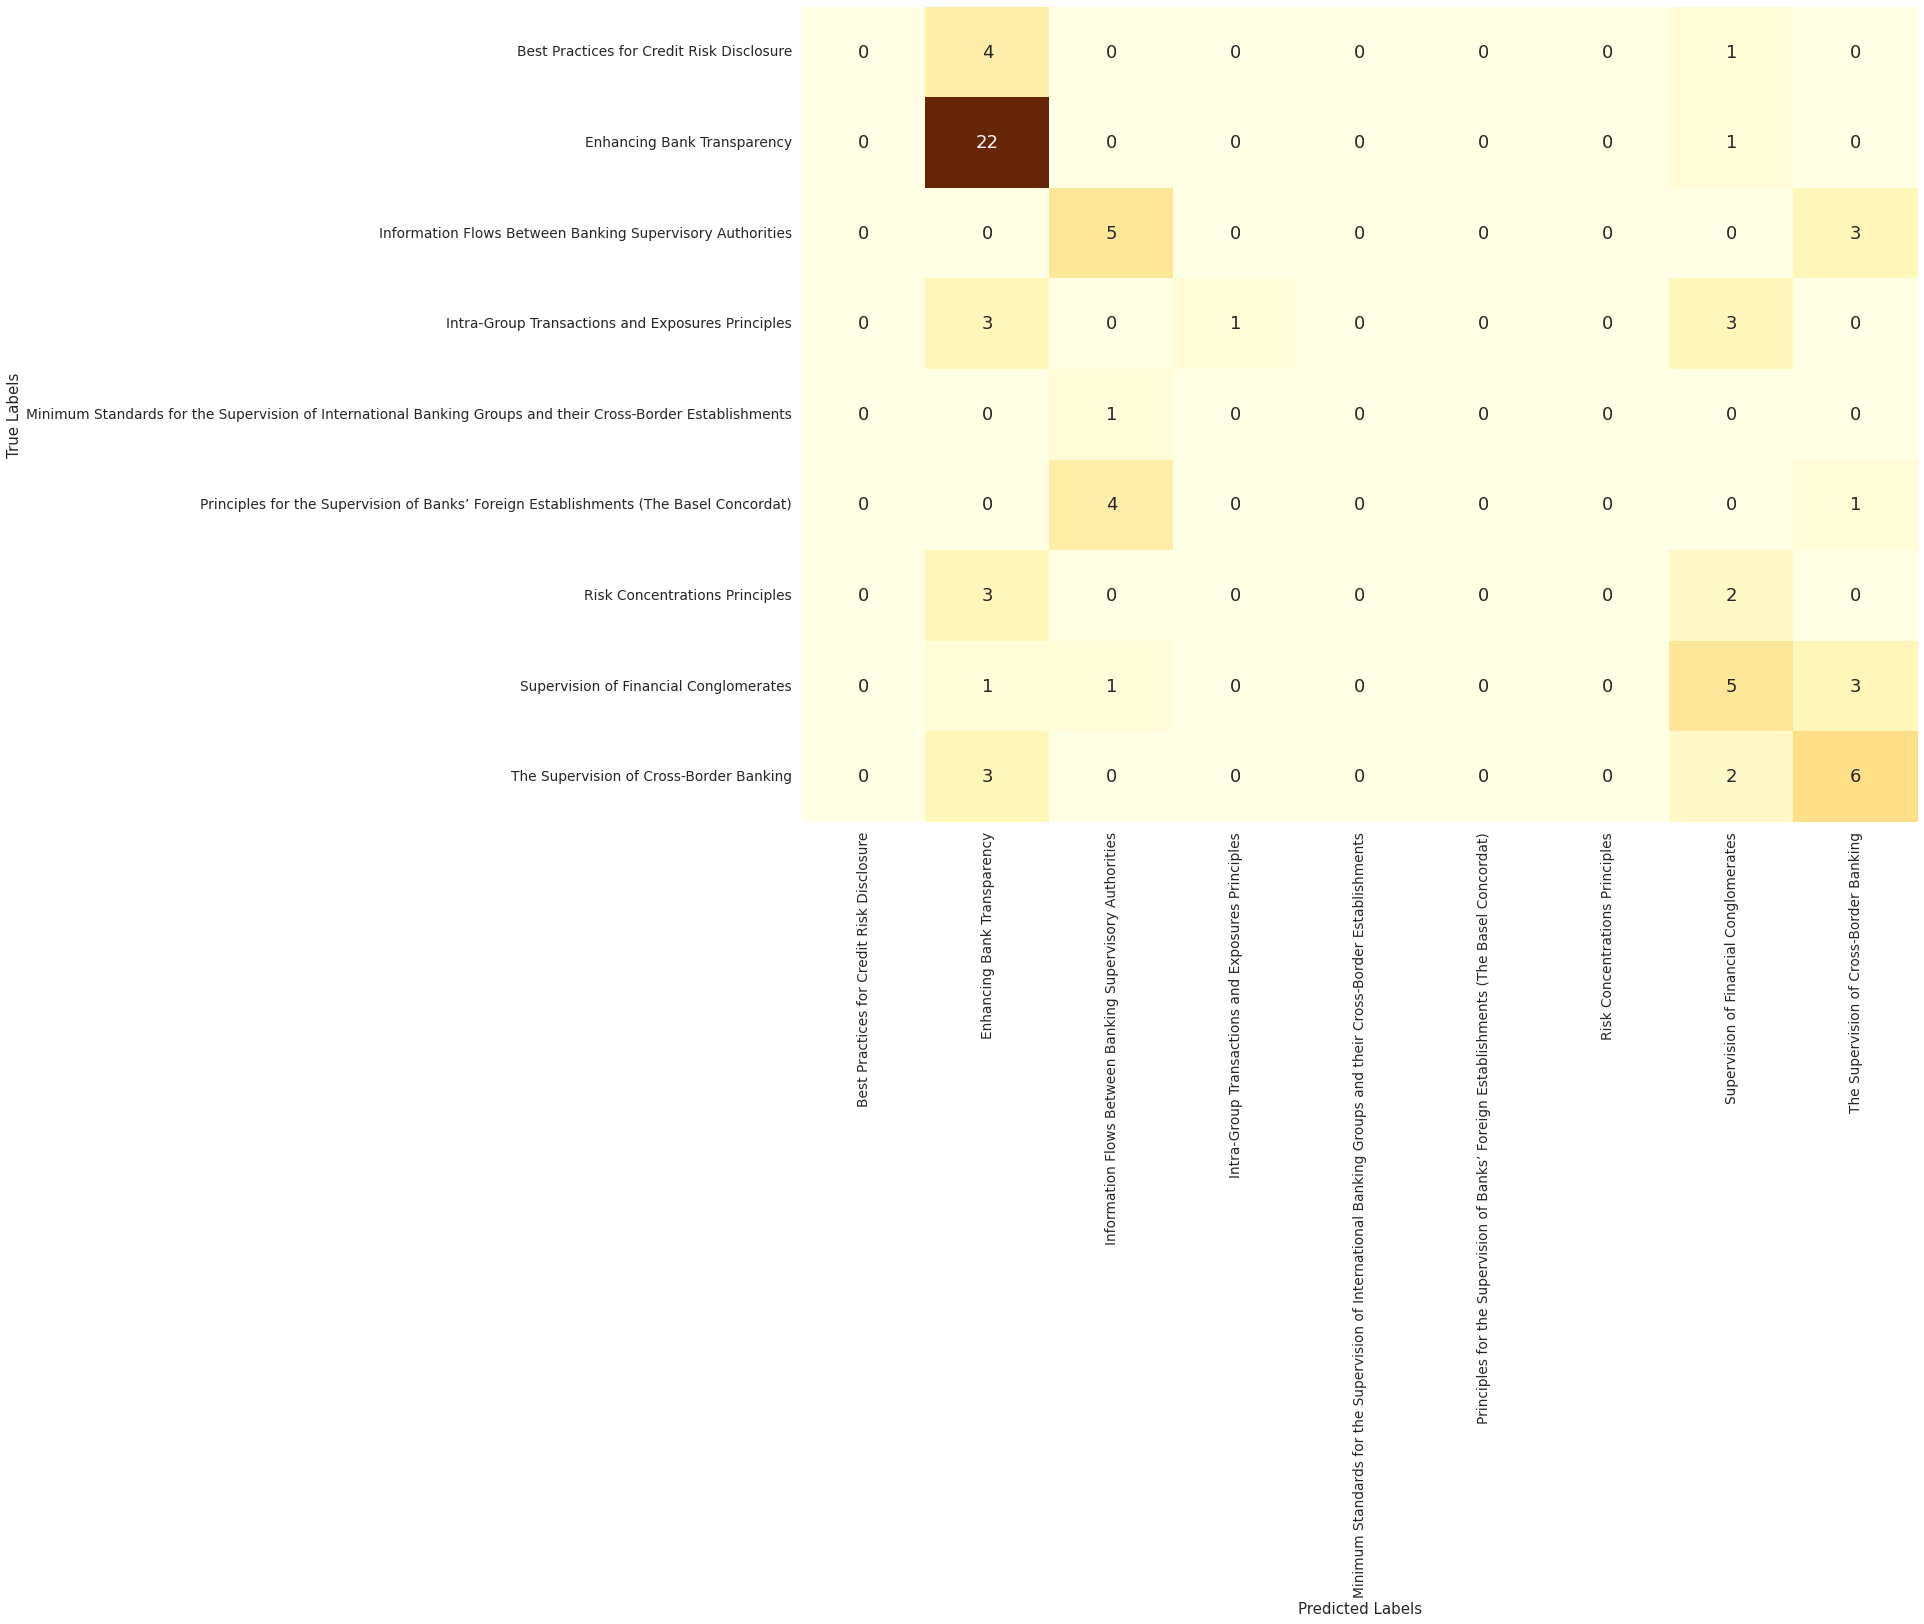

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
True_labels = top3_df["true_label"].to_list() 
Predicted_labels = top3_df["predicted_label_1"].to_list() 
cm = confusion_matrix(True_labels, Predicted_labels)
#plot the confusion matrix
print("The confusion matrix is : \n")
plt.figure(figsize=(20,15))
sns.set(font_scale=1.25)
ax =sns.heatmap(cm, annot=True, fmt='d',cbar=False,xticklabels=labels, yticklabels=labels,cmap="YlOrBr",annot_kws={"size": 18})
ax.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

In [ ]:
#Display Classification Report
from sklearn.metrics import classification_report
print(classification_report(True_labels, Predicted_labels,zero_division=0))

                                                                                                             precision    recall  f1-score   support

                                                                  Best Practices for Credit Risk Disclosure       0.00      0.00      0.00         5
                                                                                Enhancing Bank Transparency       0.61      0.96      0.75        23
                                                  Information Flows Between Banking Supervisory Authorities       0.45      0.62      0.53         8
                                                          Intra-Group Transactions and Exposures Principles       1.00      0.14      0.25         7
Minimum Standards for the Supervision of International Banking Groups and their Cross-Border Establishments       0.00      0.00      0.00         1
                      Principles for the Supervision of Banks’ Foreign Establishments (The Basel Concorda

In [ ]:
# Calculate the First Prediction Percentages
top3_df["First_Prediction_Percentage"] = (top3_df["true_label"]  == top3_df['predicted_label_1']) * 100
# Calculate the First and Second Prediction Percentages
top3_df["First_and_Second_Prediction_Percentage"] = ((top3_df["true_label"]  == top3_df['predicted_label_1']) |((top3_df["true_label"]  == top3_df['predicted_label_2']))) * 100

In [ ]:
# Calculate the accuracy of First and Second Predictions
accuracy_df = top3_df.loc[:,['true_label',"First_Prediction_Percentage", "First_and_Second_Prediction_Percentage"]].groupby('true_label').mean() 
accuracy_df 

,First_Prediction_Percentage,First_and_Second_Prediction_Percentage
true_label,,
Best Practices for Credit Risk Disclosure,0.000000,60.000000
Enhancing Bank Transparency,95.652174,95.652174
Information Flows Between Banking Supervisory Authorities,62.500000,75.000000
Intra-Group Transactions and Exposures Principles,14.285714,14.285714
Minimum Standards for the Supervision of International Banking Groups and their Cross-Border Establishments,0.000000,0.000000
Principles for the Supervision of Banks’ Foreign Establishments (The Basel Concordat),0.000000,40.000000
Risk Concentrations Principles,0.000000,0.000000
Supervision of Financial Conglomerates,50.000000,80.000000
The Supervision of Cross-Border Banking,54.545455,63.636364
